## Imports


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

# DATA PRE - PROCESSING


#1. Object Columns

In [71]:
train.select_dtypes('object').head()

,Id,idhogar,dependency,edjefe,edjefa
0,ID_279628684,21eb7fcc1,no,10,no
1,ID_f29eb3ddd,0e5d7a658,8,12,no
2,ID_68de51c94,2c7317ea8,8,no,11
3,ID_d671db89c,2b58d945f,yes,11,no
4,ID_d56d6f5f5,2b58d945f,yes,11,no


In [72]:
mapping = {"yes": 1, "no": 0}

# Apply same operation to both train and test
for df in [train, test]:
    # Fill in the values with the correct mapping
    df['dependency'] = df['dependency'].replace(mapping).astype(np.float64)
    df['edjefa'] = df['edjefa'].replace(mapping).astype(np.float64)
    df['edjefe'] = df['edjefe'].replace(mapping).astype(np.float64)


In [73]:
# Add null Target column to test
test['Target'] = np.nan
data = train.append(test, ignore_index = True)

## 2. Addressing Wrong Labels



### Identify Errors



In [74]:
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)
# Households where targets are not all equal
not_equal = all_equal[all_equal != True]

### Correct Errors


In [75]:
# Iterate through each household
for household in not_equal.index:
    # Find the correct label (for the head of household)
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    
    # Set the correct label for all members in the household
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    
    
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]

## 3. Missing Variables


In [76]:
# Number of missing in each column
missing = pd.DataFrame(data.isnull().sum()).rename(columns = {0: 'total'})

# Create a percentage missing
missing['percent'] = missing['total'] / len(data)

missing.sort_values('percent', ascending = False).head(5).drop('Target')

,total,percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
SQBmeaned,36,0.001077


In [77]:
data['v18q1'] = data['v18q1'].fillna(0)

In [78]:
# Fill in households that own the house with 0 rent payment
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

# Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()

In [79]:
# If individual is over 19 or younger than 7 and missing years behind, set it to 0
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

# Add a flag for those between 7 and 19 with a missing value
data['rez_esc-missing'] = data['rez_esc'].isnull()

In [80]:
data.loc[data['rez_esc'] > 5, 'rez_esc'] = 5

# FEATURE ENGINEERING

In [81]:
id_ = ['Id', 'idhogar', 'Target']

In [82]:
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone', 'rez_esc-missing']

ind_ordered = ['rez_esc', 'escolari', 'age']

In [83]:
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2', 'v2a1-missing']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [84]:
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

#### Squared Variables



In [85]:
# Remove squared variables
data = data.drop(columns = sqr_)
data.shape

(33413, 136)



## Household Level Variables


In [86]:
heads = data.loc[data['parentesco1'] == 1, :]
heads = heads[id_ + hh_bool + hh_cont + hh_ordered]
heads.shape

(10307, 99)

### Redundant Household Variables



In [87]:
# Create correlation matrix
corr_matrix = heads.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['coopele', 'area2', 'tamhog', 'hhsize', 'hogar_total']

In [88]:
corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9]

,r4t3,tamhog,tamviv,hhsize,hogar_total
r4t3,1.000000,0.998287,0.910457,0.998287,0.998287
tamhog,0.998287,1.000000,0.909155,1.000000,1.000000
tamviv,0.910457,0.909155,1.000000,0.909155,0.909155
hhsize,0.998287,1.000000,0.909155,1.000000,1.000000
hogar_total,0.998287,1.000000,0.909155,1.000000,1.000000


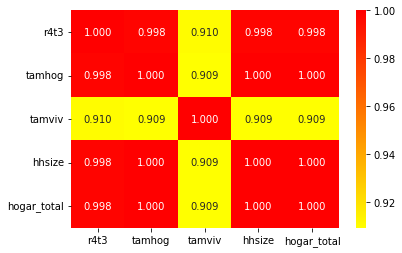

In [89]:
sns.heatmap(corr_matrix.loc[corr_matrix['tamhog'].abs() > 0.9, corr_matrix['tamhog'].abs() > 0.9],
            annot=True, cmap = plt.cm.autumn_r, fmt='.3f');

In [90]:
heads = heads.drop(columns = ['tamhog', 'hogar_total', 'r4t3'])

In [91]:
heads['hhsize-diff'] = heads['tamviv'] - heads['hhsize']

In [92]:
elec = []

# Assign values
for i, row in heads.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
# Record the new variable and missing flag
heads['elec'] = elec
heads['elec-missing'] = heads['elec'].isnull()

# Remove the electricity columns
# heads = heads.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])

In [93]:
heads = heads.drop(columns = 'area2')

In [94]:
# Wall ordinal variable
heads['walls'] = np.argmax(np.array(heads[['epared1', 'epared2', 'epared3']]),
                           axis = 1)

In [95]:
# Roof ordinal variable
heads['roof'] = np.argmax(np.array(heads[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
heads = heads.drop(columns = ['etecho1', 'etecho2', 'etecho3'])

# Floor ordinal variable
heads['floor'] = np.argmax(np.array(heads[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)
# heads = heads.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

## Feature Construction


In [96]:
# Create new feature
heads['walls+roof+floor'] = heads['walls'] + heads['roof'] + heads['floor']

In [97]:
counts = pd.DataFrame(heads.groupby(['walls+roof+floor'])['Target'].value_counts(normalize = True)).rename(columns = {'Target': 'Normalized Count'}).reset_index()
counts.head()

,walls+roof+floor,Target,Normalized Count
0,0,4.0,0.376404
1,0,2.0,0.320225
2,0,1.0,0.162921
3,0,3.0,0.140449
4,1,4.0,0.323529


In [98]:
# No toilet, no electricity, no floor, no water service, no ceiling
heads['warning'] = 1 * (heads['sanitario1'] + 
                         (heads['elec'] == 0) + 
                         heads['pisonotiene'] + 
                         heads['abastaguano'] + 
                         (heads['cielorazo'] == 0))

In [99]:
# Owns a refrigerator, computer, tablet, and television
heads['bonus'] = 1 * (heads['refrig'] + 
                      heads['computer'] + 
                      (heads['v18q1'] > 0) + 
                      heads['television'])

## Per Capita Features

In [100]:
heads['phones-per-capita'] = heads['qmobilephone'] / heads['tamviv']
heads['tablets-per-capita'] = heads['v18q1'] / heads['tamviv']
heads['rooms-per-capita'] = heads['rooms'] / heads['tamviv']
heads['rent-per-capita'] = heads['v2a1'] / heads['tamviv']

In [101]:
household_feats = list(heads.columns)

# Individual Level Variables

In [102]:
ind = data[id_ + ind_bool + ind_ordered]
ind.shape

(33413, 40)

## Redundant Individual Variables


In [103]:
# Create correlation matrix
corr_matrix = ind.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

to_drop

['female']

In [104]:
ind = ind.drop(columns = 'male')

### Creating Ordinal Variables



In [105]:
ind[[c for c in ind if c.startswith('instl')]].head()

,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9
0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0


In [106]:
ind['inst'] = np.argmax(np.array(ind[[c for c in ind if c.startswith('instl')]]), axis = 1)


### Feature Construction

We can make a few features using the existing data. For example, we can divide the years of schooling by the age.

In [107]:
ind['escolari/age'] = ind['escolari'] / ind['age']
ind['inst/age'] = ind['inst'] / ind['age']
ind['tech'] = ind['v18q'] + ind['mobilephone']

## Feature Engineering through Aggregations


In [108]:
# Define custom function
range_ = lambda x: x.max() - x.min()
range_.__name__ = 'range_'

# Group and aggregate
ind_agg = ind.drop(columns = 'Target').groupby('idhogar').agg(['min', 'max', 'sum', 'count', 'std', range_])
ind_agg.head()

v18q                            ... tech                          
           min max sum count  std range_  ...  min max sum count  std range_
idhogar                                   ...                               
000a08204    1   1   3     3  0.0      0  ...    2   2   6     3  0.0      0
000bce7c4    0   0   0     2  0.0      0  ...    1   1   2     2  0.0      0
001845fb0    0   0   0     4  0.0      0  ...    1   1   4     4  0.0      0
001ff74ca    1   1   2     2  0.0      0  ...    2   2   4     2  0.0      0
003123ec2    0   0   0     4  0.0      0  ...    1   1   4     4  0.0      0

[5 rows x 234 columns]

In [109]:
# Rename the columns
new_col = []
for c in ind_agg.columns.levels[0]:
    for stat in ind_agg.columns.levels[1]:
        new_col.append(f'{c}-{stat}')
        
ind_agg.columns = new_col
ind_agg.head()

,v18q-min,v18q-max,v18q-sum,v18q-count,v18q-std,v18q-range_,dis-min,dis-max,dis-sum,dis-count,dis-std,dis-range_,female-min,female-max,female-sum,female-count,female-std,female-range_,estadocivil1-min,estadocivil1-max,estadocivil1-sum,estadocivil1-count,estadocivil1-std,estadocivil1-range_,estadocivil2-min,estadocivil2-max,estadocivil2-sum,estadocivil2-count,estadocivil2-std,estadocivil2-range_,estadocivil3-min,estadocivil3-max,estadocivil3-sum,estadocivil3-count,estadocivil3-std,estadocivil3-range_,estadocivil4-min,estadocivil4-max,estadocivil4-sum,estadocivil4-count,...,rez_esc-sum,rez_esc-count,rez_esc-std,rez_esc-range_,escolari-min,escolari-max,escolari-sum,escolari-count,escolari-std,escolari-range_,age-min,age-max,age-sum,age-count,age-std,age-range_,inst-min,inst-max,inst-sum,inst-count,inst-std,inst-range_,escolari/age-min,escolari/age-max,escolari/age-sum,escolari/age-count,escolari/age-std,escolari/age-range_,inst/age-min,inst/age-max,inst/age-sum,inst/age-count,inst/age-std,inst/age-range_,tech-min,tech-max,tech-sum,tech-count,tech-std,tech-range_
idhogar,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000a08204,1,1,3,3,0.0,0,0,0,0,3,0.000000,0,0,1,1,3,0.577350,1,0,1,1,3,0.577350,1,0,1,2,3,0.57735,1,0,0,0,3,0.0,0,0,0,0,3,...,0.0,3,0.0,0.0,0,14,26,3,7.571878,14,4,30,62,3,14.468356,26,0,7,14,3,4.041452,7,0.000000,0.500000,0.900000,3,0.264575,0.500000,0.000000,0.250000,0.483333,3,0.139775,0.250000,2,2,6,3,0.0,0
000bce7c4,0,0,0,2,0.0,0,0,1,1,2,0.707107,1,0,1,1,2,0.707107,1,0,0,0,2,0.000000,0,0,0,0,2,0.00000,0,1,1,2,2,0.0,0,0,0,0,2,...,0.0,2,0.0,0.0,0,5,5,2,3.535534,5,60,63,123,2,2.121320,3,0,1,1,2,0.707107,1,0.000000,0.083333,0.083333,2,0.058926,0.083333,0.000000,0.016667,0.016667,2,0.011785,0.016667,1,1,2,2,0.0,0
001845fb0,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,1,2,4,0.577350,1,0,0,0,4,0.000000,0,0,1,2,4,0.57735,1,0,0,0,4,0.0,0,0,0,0,4,...,0.0,3,0.0,0.0,6,14,41,4,3.304038,8,19,52,142,4,16.421531,33,2,7,16,4,2.160247,5,0.115385,0.526316,1.397906,4,0.183106,0.410931,0.038462,0.166667,0.511959,4,0.060123,0.128205,1,1,4,4,0.0,0
001ff74ca,1,1,2,2,0.0,0,0,0,0,2,0.000000,0,1,1,2,2,0.000000,0,0,1,1,2,0.707107,1,0,0,0,2,0.00000,0,0,0,0,2,0.0,0,0,0,0,2,...,0.0,2,0.0,0.0,0,16,16,2,11.313708,16,0,38,38,2,26.870058,38,0,7,7,2,4.949747,7,0.421053,0.421053,0.421053,1,NaN,0.000000,0.184211,0.184211,0.184211,1,NaN,0.000000,2,2,4,2,0.0,0
003123ec2,0,0,0,4,0.0,0,0,0,0,4,0.000000,0,0,1,1,4,0.500000,1,0,1,2,4,0.577350,1,0,1,2,4,0.57735,1,0,0,0,4,0.0,0,0,0,0,4,...,0.0,4,0.0,0.0,0,7,13,4,3.774917,7,1,24,51,4,12.446552,23,0,3,5,4,1.500000,3,0.000000,0.304348,0.554348,4,0.161557,0.304348,0.000000,0.130435,0.213768,4,0.064636,0.130435,1,1,4,4,0.0,0


In [110]:
ind_agg.iloc[:, [0, 1, 2, 3, 6, 7, 8, 9]].head()

,v18q-min,v18q-max,v18q-sum,v18q-count,dis-min,dis-max,dis-sum,dis-count
idhogar,,,,,,,,
000a08204,1,1,3,3,0,0,0,3
000bce7c4,0,0,0,2,0,1,1,2
001845fb0,0,0,0,4,0,0,0,4
001ff74ca,1,1,2,2,0,0,0,2
003123ec2,0,0,0,4,0,0,0,4


### Feature Selection 

In [111]:
# Create correlation matrix
corr_matrix = ind_agg.corr()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

print(f'There are {len(to_drop)} correlated columns to remove.')

There are 111 correlated columns to remove.


In [112]:
ind_agg = ind_agg.drop(columns = to_drop)
ind_feats = list(ind_agg.columns)

# Merge on the household id
final = heads.merge(ind_agg, on = 'idhogar', how = 'left')

print('Final features shape: ', final.shape)

Final features shape:  (10307, 228)


In [113]:
head_gender = ind.loc[ind['parentesco1'] == 1, ['idhogar', 'female']]
final = final.merge(head_gender, on = 'idhogar', how = 'left').rename(columns = {'female': 'female-head'})

In [114]:
train_set = final[final['Target'].notnull()]
test_set = final[final['Target'].isnull()]

train_set.to_csv("final_training_set.csv")
test_set.to_csv("final_testing_set.csv")

train_set_imputed = train_set.fillna(train_set.median())
test_set_imputed = test_set.fillna(test_set.median())

train_set_imputed.to_csv("final_training_set_imputed.csv")
test_set_imputed.to_csv("final_testing_set_imputed.csv")